In [1]:
from utils.model_utils import load_vision_model

from clip_illusion import Illusion
from utils.objectives import ClassConditionalObjective

import torch
from utils.config import Domain2Dict

model_name = "resnet18"
domain_name = "imagenet"
device_id="cuda:0"
ckpt_path = None
# class_alpha = 0.8

device = torch.device(device_id if torch.cuda.is_available() else "cpu")
class_dict = Domain2Dict[domain_name]
# load model
transform, model, pool, decision, config = load_vision_model(model_name, device=device, ckpt_path=ckpt_path)
obj = ClassConditionalObjective(image_size=224, class_gamma=0.8, domain_eps=0.05)
illusion = Illusion(model, decision, obj, class_dict=class_dict, \
        device=device, img_mean=config["mean"], img_std=config["std"])

### Multiple neurons and one class in a batch

In [7]:
from utils.prompts import prepare_class_names

class_idx = 510
print(class_dict[class_idx])
batch_size = 5
target_neuron = torch.topk(decision.weight.data[class_idx], k=batch_size, dim=0, largest=True)[1]
# target_neuron = torch.LongTensor([0, 1, 2, 3])

# set neuron idx
illusion.objective_fn.channel_number = target_neuron.to(device)

# set class idx
if class_idx is None:
    # Class most related to the neuron
    dummy = torch.zeros(batch_size, illusion.decision.weight.data.shape[1])
    dummy[:,target_neuron] = 25.0
    logits = illusion.decision(dummy.to(device))
    class_indices = torch.topk(logits[0], k=batch_size, dim=0)[1]
else:
    class_indices = torch.LongTensor([class_idx for _ in range(batch_size)]).to(device)
    
illusion.objective_fn.class_idx = class_indices

# Generate Feature
class_names = prepare_class_names(class_indices, class_dict)

container ship, containership, container vessel


### One neuron and multiple classes in a batch

In [2]:
from utils.prompts import prepare_class_names

target_neuron = 1
class_idx = None
batch_size = 6

# set neuron idx
target_neuron = torch.LongTensor([target_neuron for _ in range(batch_size)]).to(device)
illusion.objective_fn.channel_number = target_neuron

# set class idx
if class_idx is None:
    # Class most related to the neuron
    dummy = torch.zeros(batch_size, illusion.decision.weight.data.shape[1])
    dummy[:,target_neuron] = 30.0
    logits = illusion.decision(dummy.to(device))
    class_indices = torch.topk(logits[0], k=batch_size, dim=0)[1]
else:
    class_indices = torch.LongTensor([class_idx for _ in range(batch_size)]).to(device)
    
illusion.objective_fn.class_idx = class_indices
print(class_indices)
# Generate Feature
class_names = prepare_class_names(class_indices, class_dict)
class_names

tensor([454, 860, 624, 453, 423, 510], device='cuda:0')


['bookshop, bookstore, bookstall',
 'tobacco shop, tobacconist shop, tobacconist',
 'library',
 'bookcase',
 'barber chair',
 'container ship, containership, container vessel']

In [8]:
# Generate CLIP-Illusion
images, acts, masks = illusion.optimize_caption_and_dream(model.layer4, batch_size=batch_size,\
                lr=9e-3, weight_decay=2e-4, iters=450, texts=class_names, quiet=False, reduction=0.4, threshold=0.2)

100%|██████████| 450/450 [00:16<00:00, 27.60it/s, loss=-19.8, lr=0.00108]


In [9]:
# torch.softmax(model(illusion.postprocess(images)), dim=-1)[:, class_idx]
probs = torch.softmax(model(illusion.postprocess(images)), dim=-1)
print(torch.argmax(probs,dim=1))
print(class_indices)
print(torch.gather(probs, 1, class_indices.unsqueeze(-1)).squeeze(1))

tensor([510, 510, 510, 510, 510], device='cuda:0')
tensor([510, 510, 510, 510, 510], device='cuda:0')
tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [10]:
import matplotlib.pyplot as plt
from utils.ops import to_rgb
from PIL import Image

_images = to_rgb(images.cpu().detach())
_acts = acts.cpu().detach().numpy()

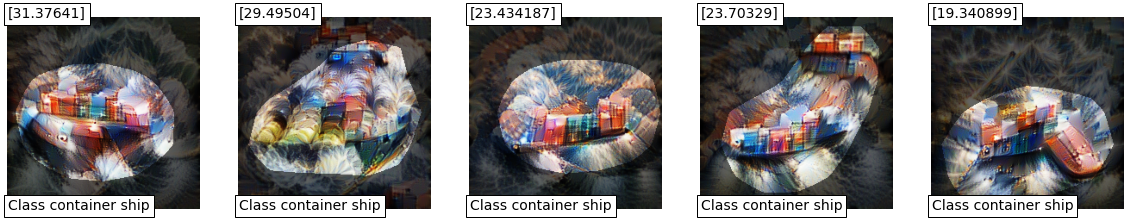

In [11]:
pil_images = [Image.fromarray(_images[i], "RGB") for i in range(batch_size)]

fig, axes = plt.subplots(1,batch_size)

fig.set_figheight(4)
fig.set_figwidth(4*batch_size)

neurons = target_neuron.tolist()

for i in range(batch_size):
    axes[i].imshow(pil_images[i]);
    axes[i].axis(False);
    axes[i].text(0.5, 0.5, _acts[i], fontsize=14, bbox=dict(facecolor="white"));
    axes[i].text(0.5, 224, "Class "+class_names[i].split(",")[0], fontsize=14, bbox=dict(facecolor="white"));
    # axes[i].text(0.5, 224, f"Class {class_names[i]}", fontsize=14, bbox=dict(facecolor="white"));